In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_palette('colorblind')
from matplotlib.pyplot import tight_layout
# ##SETTING PARAMS FOR MATPLOTLIB FIGURES
plt.rcParams.update({"figure.figsize": (6, 6),
                 "axes.facecolor": "white",
                 "axes.edgecolor": "black"})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('colorblind'))
##set font size
font = {'family': 'sans-serif',
       'weight': 'normal',
       'size': 14}
plt.rc('font', **font)
# ##PANDAS PLOTTING
pd.plotting.register_matplotlib_converters()

In [2]:
# Import necessary libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
# For inline plots in Jupyter
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

from IPython.display import Image, display
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv
import openpyxl
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

import patsy
from statsmodels.discrete.discrete_model import GeneralizedPoisson
from scipy import stats
    

## Step 2 : Import files

In [3]:
data_directory_merged = "/home/paulharford/college/project/project_data/processed/WEATHERED_nas_merged_v2.csv"
full_path_merged = os.path.abspath(data_directory_merged)

In [4]:
df_model = pd.read_csv(full_path_merged)


In [5]:
df_model.isnull().sum()

region                      0
date                        0
fall_category_group         0
callout_count               0
year                        0
warning_phenomenon          0
warning_severity            0
warning_severity_numeric    0
counties_in_region          0
county_weight               0
weather_event               0
population                  0
log_population              0
month                       0
season                      0
is_winter                   0
is_spring                   0
is_summer                   0
is_autumn                   0
severity_group              0
severity_group_detailed     0
severity_group_simple       0
dtype: int64

In [6]:
df_model = df_model.copy()

df_model['date'] = pd.to_datetime(df_model['date'])
df_model['is_weekend'] = df_model['date'].dt.dayofweek.isin([5, 6]).astype(int)
df_model['day_of_week'] = df_model['date'].dt.dayofweek
df_model['callout_count_lag7'] = df_model.groupby('region')['callout_count'].shift(7)
df_model['is_cold_weather'] = df_model['warning_phenomenon'].isin([
    'Low-Temperature', 'Low-Temperature_Ice', 'Ice', 'Snow_Ice']).astype(int)
df_model['is_extreme_cold'] = (
    df_model['warning_phenomenon'].isin(['Low-Temperature_Ice', 'Ice']) &
    (df_model['warning_severity_numeric'] >= 2)  # Orange/Red only
).astype(int)


df_model_clean = df_model.dropna()

# Comprehensive model
y, X = patsy.dmatrices(
    "callout_count ~ "
    # Time effects
    "C(year, Treatment(reference=2017)) + "
    #"C(month, Treatment(reference=1)) + "
    "is_weekend + "
    # Location effects  
    "C(region, Treatment(reference='HSE Mid West')) + "
    # Fall severity effects
    "C(severity_group_detailed) + "
    "is_cold_weather:C(severity_group_detailed) + "
    "is_cold_weather:C(region, Treatment(reference='HSE Mid West')) + "
    "C(region, Treatment(reference='HSE Mid West')):C(severity_group_detailed) ",  # Regional variations
    data=df_model_clean,
    return_type='dataframe'
)

# Define the offset - 
offset = df_model.loc[y.index, "log_population"]

### Fit Poisson Model (For Underdispersion)
print("\n" + "="*60)
print("FITTING GENERALIZED POISSON MODEL (FOR UNDERDISPERSION)")
print("="*60)

# Convert y to 1D array
y_array = np.asarray(y).flatten()

try:
    gp_model = GeneralizedPoisson(endog=y_array, exog=X, offset=offset)
    gp_results = gp_model.fit(maxiter=1000, disp=False)
    
    print("\nGeneralized Poisson Model Summary:")
    print(gp_results.summary())
    gp_fitted = True
except Exception as e:
    print(f"\nGeneralized Poisson model failed: {e}")
    gp_fitted = False


FITTING GENERALIZED POISSON MODEL (FOR UNDERDISPERSION)

Generalized Poisson Model Summary:
                    GeneralizedPoisson Regression Results                     
Dep. Variable:                      y   No. Observations:                58034
Model:             GeneralizedPoisson   Df Residuals:                    57993
Method:                           MLE   Df Model:                           40
Date:                Fri, 25 Jul 2025   Pseudo R-squ.:                 0.07607
Time:                        11:10:49   Log-Likelihood:                -86404.
converged:                       True   LL-Null:                       -93517.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

In [7]:
# 1. National trend over time
def plot_national_trend(df):
    """Plot national callout trends over time"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Aggregate by year
    yearly_data = df.groupby('year').agg({
        'callout_count': ['sum', 'mean', 'std'],
        'population': 'sum'
    }).reset_index()
    
    # Plot total callouts
    ax1.plot(yearly_data['year'], yearly_data['callout_count']['sum'], 
             marker='o', linewidth=3, markersize=10, color='#2E86AB')
    ax1.fill_between(yearly_data['year'], 
                     yearly_data['callout_count']['sum'] - yearly_data['callout_count']['std'],
                     yearly_data['callout_count']['sum'] + yearly_data['callout_count']['std'],
                     alpha=0.2, color='#2E86AB')
    
    # Add percentage change annotations
    for i in range(1, len(yearly_data)):
        pct_change = ((yearly_data['callout_count']['sum'].iloc[i] - 
                      yearly_data['callout_count']['sum'].iloc[i-1]) / 
                     yearly_data['callout_count']['sum'].iloc[i-1] * 100)
        ax1.annotate(f'+{pct_change:.1f}%', 
                    xy=(yearly_data['year'].iloc[i], yearly_data['callout_count']['sum'].iloc[i]),
                    xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)
    
    ax1.set_title('Fall Related NAS Callouts from 2016 to 2023', fontsize=12)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Total Callouts', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot rate per 50,000 population
    yearly_data['rate_per_50k'] = (yearly_data['callout_count']['sum'] / 
                                    yearly_data['population']['sum'] * 50000)
    
    ax2.bar(yearly_data['year'], yearly_data['rate_per_50k'], 
            color='#A23B72', alpha=0.7, edgecolor='black')
    ax2.set_title('Callouts per 50k per year ', fontsize=12)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Rate per 50k', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# 2. Top 5 fall categories
def plot_top_categories(df):
    """Plot top 3 fall categories with trends"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Get top 5 categories
    top_3 = df['severity_group_detailed'].value_counts().head(3)
    
    # Bar plot
    bars = ax1.barh(top_3.index, top_3.values, color=sns.color_palette("rocket", 3))
    ax1.set_xlabel('Total Callouts', fontsize=12)
    ax1.set_title('Top 3 Fall Categories (excluding minor)', fontsize=12, fontweight='bold')
    
    # Add value labels
    for i, (cat, val) in enumerate(top_3.items()):
        ax1.text(val + 500, i, f'{val:,}', va='center', fontsize=10)
    
    # Trend over time for top 3
    for cat in top_3.index:
        cat_data = df[df['severity_group_detailed'] == cat].groupby('year')['callout_count'].sum()
        ax2.plot(cat_data.index, cat_data.values, marker='o', label=cat, linewidth=2)
    
    ax2.set_title('Trends for Top 3 Categories Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Total Callouts', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_weather_effects(gp_results, df):
    """Plot weather interaction effects with confidence intervals"""
    fig = plt.figure(figsize=(12, 10))
    
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 1, 2)
    
    # Extract weather interaction coefficients
    weather_params = []
    param_names = list(gp_results.params.index)
    
    # Add reference category with zero effect
    weather_params.append({
        'category': 'fall_moderate (reference)',
        'coefficient': 0,
        'ci_lower': 0,
        'ci_upper': 0,
        'p_value': 1.0,
        'significant': False
    })
    
    for i, param in enumerate(param_names):
        if 'is_cold_weather:C(severity_group_detailed)' in param:
            # Extract category name - it's in square brackets
            if '[' in param and ']' in param:
                cat = param.split('[')[1].split(']')[0]
            else:
                continue
            
            # Use iloc for proper indexing
            coef = gp_results.params.iloc[i]
            se = gp_results.bse.iloc[i]
            ci_lower = coef - 1.96 * se
            ci_upper = coef + 1.96 * se
            p_value = gp_results.pvalues.iloc[i]
            
            weather_params.append({
                'category': cat,
                'coefficient': coef,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'p_value': p_value,
                'significant': p_value < 0.05
            })
    
    weather_df = pd.DataFrame(weather_params)
    weather_df = weather_df.sort_values('coefficient', ascending=True)
    
    # Plot coefficients with CI
    y_pos = np.arange(len(weather_df))
    
    # Color based on significance
    colors = ['red' if sig else 'gray' for sig in weather_df['significant']]
    
    # Calculate error bars - FIX: weather_df not weather*df
    errors = np.array([[row['coefficient'] - row['ci_lower'],
                       row['ci_upper'] - row['coefficient']] 
                      for _, row in weather_df.iterrows()]).T
    
    ax1.barh(y_pos, weather_df['coefficient'], xerr=errors,
             color=colors, alpha=0.6, edgecolor='black', capsize=5)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(weather_df['category'])
    ax1.set_xlabel('Coefficient (Log Scale)', fontsize=12)
    ax1.set_title('Cold Weather Effects by Fall Category\n(Red = Significant at p<0.05)', 
                  fontsize=12, fontweight='bold')
    
    # Add p-values
    for i, (_, row) in enumerate(weather_df.iterrows()):
        ax1.text(0.5, i, f'p={row["p_value"]:.3f}', 
                transform=ax1.get_yaxis_transform(), fontsize=9, va='center')
    
    # Plot what could be with better data (simulation)
    simulated_effects = weather_df.copy()
    simulated_effects['coefficient'] = simulated_effects['coefficient'] * 3  # Triple effect sizes
    simulated_effects['ci_lower'] = simulated_effects['coefficient'] - 0.05  # Tighter CIs
    simulated_effects['ci_upper'] = simulated_effects['coefficient'] + 0.05
    
    # Calculate simulated error bars - FIX: simulated_effects not simulated*effects
    sim_errors = np.array([[row['coefficient'] - row['ci_lower'],
                           row['ci_upper'] - row['coefficient']] 
                          for _, row in simulated_effects.iterrows()]).T
    
    ax2.barh(y_pos, simulated_effects['coefficient'], xerr=sim_errors,
             color='orange', alpha=0.6, edgecolor='black', capsize=5)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(weather_df['category'])
    ax2.set_xlabel('Coefficient (Log Scale)', fontsize=12)
    #ax2.set_title('Potential Weather Effects with Better Data\n(Hypothetical with 3x Effect Size & More Precision)', 
                  #fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

In [8]:
# 1. Regional trends over time - INDIVIDUAL PLOTS
def plot_regional_trends_individual(df, save_path):
    """Create individual trend plots for each region"""
    regions = sorted(df['region'].unique())
    saved_files = []
    
    for region in regions:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Filter data for this region
        region_data = df[df['region'] == region]
        
        # Aggregate by year
        yearly_data = region_data.groupby('year').agg({
            'callout_count': ['sum', 'mean', 'std'],
            'population': 'sum'
        }).reset_index()
        yearly_data.columns = ['year', 'callout_sum', 'callout_mean', 'callout_std', 'population_sum']
        
        # Plot total callouts
        ax1.plot(yearly_data['year'], yearly_data['callout_sum'], 
                 marker='o', linewidth=3, markersize=10, color='#2E86AB')
        ax1.fill_between(yearly_data['year'], 
                         yearly_data['callout_sum'] - yearly_data['callout_std'],
                         yearly_data['callout_sum'] + yearly_data['callout_std'],
                         alpha=0.2, color='#2E86AB')
        
        # Add percentage change annotations
        for i in range(1, len(yearly_data)):
            if yearly_data['callout_sum'].iloc[i-1] > 0:
                pct_change = ((yearly_data['callout_sum'].iloc[i] - 
                              yearly_data['callout_sum'].iloc[i-1]) / 
                             yearly_data['callout_sum'].iloc[i-1] * 100)
                ax1.annotate(f'{pct_change:+.1f}%', 
                            xy=(yearly_data['year'].iloc[i], yearly_data['callout_sum'].iloc[i]),
                            xytext=(0, 10), textcoords='offset points', ha='center', fontsize=10)
        
        ax1.set_title(f'Fall Related NAS Callouts from 2016 to 2023', fontsize=12)
        ax1.set_xlabel('Year', fontsize=12)
        ax1.set_ylabel('Total Callouts', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Plot rate per 50,000 population
        yearly_data['rate_per_50k'] = (yearly_data['callout_sum'] / 
                                        yearly_data['population_sum'] * 50000)
        
        ax2.bar(yearly_data['year'], yearly_data['rate_per_50k'], 
                color='#A23B72', alpha=0.7, edgecolor='black')
        ax2.set_title(f'Rate per 50k Population', fontsize=12)
        ax2.set_xlabel('Year', fontsize=12)
        ax2.set_ylabel('Callouts per 50k per year', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add average line
        avg_rate = yearly_data['rate_per_50k'].mean()
        ax2.axhline(y=avg_rate, color='red', linestyle='--', alpha=0.5, 
                    label=f'Average: {avg_rate:.1f}')
        ax2.legend()
        
        plt.tight_layout()
        
        # Save with region-specific filename
        region_clean = region.replace(' ', '_').replace('&', 'and')
        filename = os.path.join(save_path, f'trend_{region_clean}.png')
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        saved_files.append(filename)
        
    return saved_files

# 2. Top categories by region
def plot_top_categories_by_region(df, save_path):
    """Create top category plots for each region"""
    regions = sorted(df['region'].unique())
    saved_files = []
    
    for region in regions:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Filter data for this region
        region_data = df[df['region'] == region]
        
        # Get top 3 categories for this region
        top_3 = region_data['severity_group_detailed'].value_counts().head(3)
        
        # Bar plot
        colors = sns.color_palette("rocket", 5)
        bars = ax1.barh(range(len(top_3)), top_3.values, color=colors)
        ax1.set_yticks(range(len(top_3)))
        ax1.set_yticklabels(top_3.index)
        ax1.set_xlabel('Total Callouts', fontsize=12)
        ax1.set_title(f'Top 3 Fall Categories(excluding minor)', fontsize=12, fontweight='bold')
        
        # Add value labels and percentages
        total = region_data['severity_group_detailed'].count()
        for i, val in enumerate(top_3.values):
            pct = val / total * 100
            ax1.text(val + 50, i, f'{val:,} ({pct:.1f}%)', va='center', fontsize=12)
        
        # Trend over time for top 5
        for i, cat in enumerate(top_3.index):
            cat_data = region_data[region_data['severity_group_detailed'] == cat].groupby('year')['callout_count'].sum()
            ax2.plot(cat_data.index, cat_data.values, marker='o', label=cat, 
                    linewidth=2, color=colors[i])
        
        ax2.set_title(f'Category Trends Over Time', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Year', fontsize=12)
        ax2.set_ylabel('Total Callouts', fontsize=12)
        ax2.legend(fontsize=12, loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save
        region_clean = region.replace(' ', '_').replace('&', 'and')
        filename = os.path.join(save_path, f'categories_{region_clean}.png')
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        saved_files.append(filename)
        
    return saved_files

# 3. Weather analysis by region - INDIVIDUAL PLOTS
def plot_weather_analysis_by_region(df, save_path):
    """Create weather analysis plots for each region"""
    regions = sorted(df['region'].unique())
    saved_files = []
    
    for region in regions:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Filter data for this region
        region_data = df[df['region'] == region]
        
        # 1. Extreme cold frequency over time
        cold_by_year = region_data.groupby('year')['is_cold_weather'].agg(['sum', 'mean'])
        cold_by_year['mean_pct'] = cold_by_year['mean'] * 100
        
        ax1.bar(cold_by_year.index, cold_by_year['mean_pct'], color='lightblue', edgecolor='black')
        ax1.set_title(f'{region}: Extreme Cold Days by Year', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('% Days with Cold/Ice weather events')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for year, pct in zip(cold_by_year.index, cold_by_year['mean_pct']):
            ax1.text(year, pct + 0.1, f'{pct:.1f}%', ha='center', fontsize=8)
        
        # 2. Callouts on extreme cold vs normal days
        cold_callouts = region_data.groupby('is_cold_weather')['callout_count'].agg(['mean', 'std', 'count'])
        
        x = ['Normal Days', 'Cold Days']
        means = [cold_callouts.loc[0, 'mean'], cold_callouts.loc[1, 'mean']] if 1 in cold_callouts.index else [cold_callouts.loc[0, 'mean'], 0]
        stds = [cold_callouts.loc[0, 'std'], cold_callouts.loc[1, 'std']] if 1 in cold_callouts.index else [cold_callouts.loc[0, 'std'], 0]
        
        bars = ax2.bar(x, means, yerr=stds, capsize=10, color=['green', 'red'], alpha=0.7)
        ax2.set_title(f'Average Callouts by Weather', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Average Callouts per Day')
        
        # Add value labels
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                    f'{mean:.2f}', ha='center', va='bottom')
        
        # 3. Seasonal distribution of callouts
        seasonal_data = region_data.groupby(['is_winter', 'is_spring', 'is_summer', 'is_autumn'])['callout_count'].sum()
        seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
        season_values = []
        
        # Extract seasonal values
        for season_flags in [(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)]:
            if season_flags in seasonal_data.index:
                season_values.append(seasonal_data[season_flags])
            else:
                season_values.append(0)
        
        ax3.pie(season_values, labels=seasons, autopct='%1.1f%%', startangle=90)
        ax3.set_title(f'Callouts by Season', fontsize=12, fontweight='bold')
        
        # 4. Weekend effect in this region
        weekend_data = region_data.groupby('is_weekend')['callout_count'].mean()
        weekend_effect = ((weekend_data[1] - weekend_data[0]) / weekend_data[0] * 100) if 1 in weekend_data.index else 0
        
        ax4.bar(['Weekday', 'Weekend'], [weekend_data[0], weekend_data[1] if 1 in weekend_data.index else 0], 
                color=['blue', 'orange'], alpha=0.7)
        ax4.set_title(f'Weekend Effect ({weekend_effect:+.1f}%)', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Average Callouts')
        
        # Add value labels
        for i, (day, val) in enumerate(zip(['Weekday', 'Weekend'], 
                                           [weekend_data[0], weekend_data[1] if 1 in weekend_data.index else 0])):
            ax4.text(i, val + 0.05, f'{val:.2f}', ha='center')
        
        #plt.suptitle(f'{region}: Weather and Temporal Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        # Save
        region_clean = region.replace(' ', '_').replace('&', 'and')
        filename = os.path.join(save_path, f'weather_analysis_{region_clean}.png')
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        saved_files.append(filename)
        
    return saved_files

# 4. Category severity breakdown by region
def plot_severity_breakdown_by_region(df, save_path):
    """Create severity breakdown plots for each region"""
    regions = sorted(df['region'].unique())
    saved_files = []
    
    for region in regions:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Filter data for this region
        region_data = df[df['region'] == region]
        
        # 1. Distribution of severity types
        severity_dist = region_data['severity_group_detailed'].value_counts()
        
        # Create pie chart
        colors = plt.cm.Set3(np.linspace(0, 1, len(severity_dist)))
        wedges, texts, autotexts = ax1.pie(severity_dist.values, 
                                           labels=severity_dist.index, 
                                           autopct='%1.1f%%',
                                           colors=colors,
                                           startangle=90)
        
        # Improve label positioning
        for text in texts:
            text.set_fontsize(9)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(8)
        
        ax1.set_title(f'{region}: Distribution of Fall Severities', fontsize=14, fontweight='bold')
        
        # 2. Severity trends over time
       # for severity in severity_dist.index[:5]:  # Top 5 severities
       #     sev_data = region_data[region_data['severity_group_detailed'] == severity].groupby('year')['callout_count'].sum()
        #    ax2.plot(sev_data.index, sev_data.values, marker='o', label=severity, linewidth=2)
        
       # ax2.set_title(f'{region}: Severity Trends Over Time', fontsize=14, fontweight='bold')
       # ax2.set_xlabel('Year', fontsize=12)
       # ax2.set_ylabel('Total Callouts', fontsize=12)
       # ax2.legend(fontsize=8, loc='best')
       # ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save
        region_clean = region.replace(' ', '_').replace('&', 'and')
        filename = os.path.join(save_path, f'severity_{region_clean}.png')
        fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
        saved_files.append(filename)
        
    return saved_files

In [9]:

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from IPython.display import Image, display

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def create_all_nas_plots(df, gp_results, save_path='./nas_analysis/'):
    """
    Create comprehensive NAS analysis plots - both national and regional
    
    Parameters:
    -----------
    df : DataFrame
        The cleaned dataframe with all NAS data
    gp_results : statsmodels results object
        Results from the Generalized Poisson model
    save_path : str
        Base directory for saving all plots
    
    Returns:
    --------
    dict : Dictionary containing paths to all saved files organized by category
    """
    
    # Create directory structure
    structure = {
        'national': {
            'overview': 'national/overview',
            'weather': 'national/weather',
            'categories': 'national/categories'
        },
        'regional': {
            'trends': 'regional/trends',
            'categories': 'regional/categories',
            'weather': 'regional/weather',
            'severity': 'regional/severity'
        }
    }
    
    # Create all directories
    full_paths = {}
    for main_cat, subcats in structure.items():
        full_paths[main_cat] = {}
        for subcat, path in subcats.items():
            full_path = os.path.join(save_path, path)
            os.makedirs(full_path, exist_ok=True)
            full_paths[main_cat][subcat] = full_path
    
    all_saved_files = {
        'national': {},
        'regional': {}
    }
    
    print("="*60)
    print("CREATING NATIONAL ANALYSIS PLOTS")
    print("="*60)
    
    # 1. NATIONAL PLOTS
    
    # 1.1 National Overview
    print("\n1. Creating national overview plots...")
    
    # National trend plot
    fig1 = plot_national_trend(df)
    file1 = os.path.join(full_paths['national']['overview'], 'national_trend.png')
    fig1.savefig(file1, dpi=300, bbox_inches='tight')
    plt.close(fig1)
    all_saved_files['national']['trend'] = file1
    print(f"   ✓ National trend saved")
    
    # National summary statistics
    fig_summary = create_national_summary(df)
    file_summary = os.path.join(full_paths['national']['overview'], 'national_summary.png')
    fig_summary.savefig(file_summary, dpi=300, bbox_inches='tight')
    plt.close(fig_summary)
    all_saved_files['national']['summary'] = file_summary
    print(f"   ✓ National summary saved")
    
    # 1.2 National Category Analysis
    print("\n2. Creating national category analysis...")
    
    # Top categories
    fig2 = plot_top_categories(df)
    file2 = os.path.join(full_paths['national']['categories'], 'top_categories.png')
    fig2.savefig(file2, dpi=300, bbox_inches='tight')
    plt.close(fig2)
    all_saved_files['national']['categories'] = file2
    print(f"   ✓ Top categories saved")
    
    # Category distribution
    fig_cat_dist = plot_category_distribution(df)
    file_cat_dist = os.path.join(full_paths['national']['categories'], 'category_distribution.png')
    fig_cat_dist.savefig(file_cat_dist, dpi=300, bbox_inches='tight')
    plt.close(fig_cat_dist)
    all_saved_files['national']['category_dist'] = file_cat_dist
    print(f"   ✓ Category distribution saved")
    
    # 1.3 National Weather Analysis
    print("\n3. Creating national weather analysis...")
    
    # Weather effects
    fig3 = plot_weather_effects(gp_results, df)
    file3 = os.path.join(full_paths['national']['weather'], 'weather_effects.png')
    fig3.savefig(file3, dpi=300, bbox_inches='tight')
    plt.close(fig3)
    all_saved_files['national']['weather_effects'] = file3
    print(f"   ✓ Weather effects saved")
    
    # Weather patterns
    fig_weather_patterns = plot_national_weather_patterns(df)
    file_weather_patterns = os.path.join(full_paths['national']['weather'], 'weather_patterns.png')
    fig_weather_patterns.savefig(file_weather_patterns, dpi=300, bbox_inches='tight')
    plt.close(fig_weather_patterns)
    all_saved_files['national']['weather_patterns'] = file_weather_patterns
    print(f"   ✓ Weather patterns saved")
    
    print("\n" + "="*60)
    print("CREATING REGIONAL ANALYSIS PLOTS")
    print("="*60)
    
    # 2. REGIONAL PLOTS
    regions = sorted(df['region'].unique())
    all_saved_files['regional'] = {region: {} for region in regions}
    
    # 2.1 Regional Trends
    print("\n4. Creating regional trend plots...")
    trend_files = plot_regional_trends_individual(df, full_paths['regional']['trends'])
    for file in trend_files:
        region = extract_region_from_filename(file)
        if region:
            all_saved_files['regional'][region]['trend'] = file
    print(f"   ✓ Created {len(trend_files)} regional trend plots")
    
    # 2.2 Regional Categories
    print("\n5. Creating regional category plots...")
    cat_files = plot_top_categories_by_region(df, full_paths['regional']['categories'])
    for file in cat_files:
        region = extract_region_from_filename(file)
        if region:
            all_saved_files['regional'][region]['categories'] = file
    print(f"   ✓ Created {len(cat_files)} regional category plots")
    
    # 2.3 Regional Weather
    print("\n6. Creating regional weather analysis plots...")
    weather_files = plot_weather_analysis_by_region(df, full_paths['regional']['weather'])
    for file in weather_files:
        region = extract_region_from_filename(file)
        if region:
            all_saved_files['regional'][region]['weather'] = file
    print(f"   ✓ Created {len(weather_files)} regional weather plots")
    
    # 2.4 Regional Severity
    print("\n7. Creating regional severity breakdown plots...")
    severity_files = plot_severity_breakdown_by_region(df, full_paths['regional']['severity'])
    for file in severity_files:
        region = extract_region_from_filename(file)
        if region:
            all_saved_files['regional'][region]['severity'] = file
    print(f"   ✓ Created {len(severity_files)} regional severity plots")
    
    # 3. CREATE COMPARISON PLOTS
    print("\n" + "="*60)
    print("CREATING COMPARISON PLOTS")
    print("="*60)
    
    # Regional comparison
    fig_regional_comp = create_regional_comparison(df, gp_results)
    file_regional_comp = os.path.join(full_paths['national']['overview'], 'regional_comparison.png')
    fig_regional_comp.savefig(file_regional_comp, dpi=300, bbox_inches='tight')
    plt.close(fig_regional_comp)
    all_saved_files['national']['regional_comparison'] = file_regional_comp
    print("   ✓ Regional comparison saved")
    
    # 4. SUMMARY REPORT
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    # Count files
    national_count = sum(1 for cat in all_saved_files['national'].values() if isinstance(cat, str))
    regional_count = sum(len(region_data) for region_data in all_saved_files['regional'].values())
    
    print(f"\nTotal plots created: {national_count + regional_count}")
    print(f"  - National plots: {national_count}")
    print(f"  - Regional plots: {regional_count}")
    print(f"\nBase directory: {os.path.abspath(save_path)}")
    
    # Save plot inventory
    inventory_file = os.path.join(save_path, 'plot_inventory.txt')
    with open(inventory_file, 'w') as f:
        f.write("NAS ANALYSIS PLOT INVENTORY\n")
        f.write("="*60 + "\n\n")
        
        f.write("NATIONAL PLOTS:\n")
        for category, file in all_saved_files['national'].items():
            if isinstance(file, str):
                f.write(f"  - {category}: {os.path.basename(file)}\n")
        
        f.write("\nREGIONAL PLOTS:\n")
        for region in regions:
            f.write(f"\n  {region}:\n")
            if region in all_saved_files['regional']:
                for category, file in all_saved_files['regional'][region].items():
                    f.write(f"    - {category}: {os.path.basename(file)}\n")
    
    print(f"\nPlot inventory saved to: {inventory_file}")
    
    return all_saved_files, full_paths

# Helper function to extract region from filename
def extract_region_from_filename(filename):
    """Extract region name from filename"""
    basename = os.path.basename(filename)
    # Remove file extension and prefix
    name_part = basename.replace('.png', '').split('_', 1)[-1]
    # Convert back to region name
    region_map = {
        'HSE_Dublin_and_Midlands': 'HSE Dublin and Midlands',
        'HSE_Dublin_and_North_East': 'HSE Dublin and North East',
        'HSE_Dublin_and_South_East': 'HSE Dublin and South East',
        'HSE_Mid_West': 'HSE Mid West',
        'HSE_South_West': 'HSE South West',
        'HSE_West_and_North_West': 'HSE West and North West'
    }
    for key, value in region_map.items():
        if key in basename:
            return value
    return None

# Additional national plots

def create_national_summary(df):
    """Create a summary dashboard for national statistics"""
    fig = plt.figure(figsize=(15, 10))
    
    # Calculate summary statistics
    total_callouts = df['callout_count'].sum()
    avg_daily = df.groupby('date')['callout_count'].sum().mean()
    total_days = df['date'].nunique()
    years = sorted(df['year'].unique())
    
    # Create daily totals dataframe for proper aggregation
    daily_totals = df.groupby('date').agg({
        'callout_count': 'sum',
        'month': 'first',
        'day_of_week': 'first'
    }).reset_index()
    
    # 1. Key metrics
    ax1 = plt.subplot(2, 3, 1)
    ax1.text(0.5, 0.8, 'Total Callouts', ha='center', fontsize=16, fontweight='bold')
    ax1.text(0.5, 0.5, f'{int(total_callouts):,}', ha='center', fontsize=24, color='blue')
    ax1.text(0.5, 0.2, f'Over {len(years)} years', ha='center', fontsize=12)
    ax1.axis('off')
    
    # 2. Daily average
    ax2 = plt.subplot(2, 3, 2)
    ax2.text(0.5, 0.8, 'Average Daily Callouts', ha='center', fontsize=16, fontweight='bold')
    ax2.text(0.5, 0.5, f'{avg_daily:.1f}', ha='center', fontsize=24, color='green')
    ax2.text(0.5, 0.2, f'Across {total_days:,} days', ha='center', fontsize=12)
    ax2.axis('off')
    
    # 3. Growth rate
    first_year = df[df['year'] == years[0]]['callout_count'].sum()
    last_year = df[df['year'] == years[-1]]['callout_count'].sum()
    growth_rate = ((last_year - first_year) / first_year) * 100
    
    ax3 = plt.subplot(2, 3, 3)
    ax3.text(0.5, 0.8, 'Total Growth', ha='center', fontsize=16, fontweight='bold')
    ax3.text(0.5, 0.5, f'{growth_rate:+.1f}%', ha='center', fontsize=24, 
             color='red' if growth_rate > 0 else 'green')
    ax3.text(0.5, 0.2, f'{years[0]} to {years[-1]}', ha='center', fontsize=12)
    ax3.axis('off')
    
    # 4. Monthly distribution - FIXED
    ax4 = plt.subplot(2, 3, 4)
    monthly_avg = daily_totals.groupby('month')['callout_count'].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax4.bar(months, monthly_avg.values, color='skyblue', edgecolor='black')
    ax4.set_title('Average Daily Callouts by Month', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Average Daily Callouts')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Day of week pattern - FIXED
    ax5 = plt.subplot(2, 3, 5)
    dow_avg = daily_totals.groupby('day_of_week')['callout_count'].mean()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax5.plot(days, dow_avg.values, marker='o', linewidth=2, markersize=8, color='purple')
    ax5.set_title('Average Daily Callouts by Day of Week', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Average Daily Callouts')
    ax5.grid(True, alpha=0.3)
    
    # 6. Severity distribution
    ax6 = plt.subplot(2, 3, 6)
    severity_dist = df['severity_group_detailed'].value_counts().head(6)
    colors = plt.cm.Set3(np.linspace(0, 1, len(severity_dist)))
    wedges, texts, autotexts = ax6.pie(severity_dist.values, labels=severity_dist.index, 
                                        autopct='%1.1f%%', colors=colors, startangle=90)
    for text in texts:
        text.set_fontsize(8)
    ax6.set_title('Distribution by Severity', fontsize=14, fontweight='bold')
    
    #plt.suptitle('National Ambulance Service - Fall-Related Callouts Summary', 
                 #fontsize=18, fontweight='bold')
    plt.tight_layout()
    
    return fig

def plot_category_distribution(df):
    """Create detailed category distribution plot"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full distribution
    cat_counts = df['severity_group_detailed'].value_counts()
    
    ax1.barh(range(len(cat_counts)), cat_counts.values, 
             color=sns.color_palette("viridis", len(cat_counts)))
    ax1.set_yticks(range(len(cat_counts)))
    ax1.set_yticklabels(cat_counts.index)
    ax1.set_xlabel('Total Callouts', fontsize=12)
    ax1.set_title('All Fall Categories - Total Counts', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, val in enumerate(cat_counts.values):
        ax1.text(val + 100, i, f'{val:,}', va='center')
    
    # Percentage breakdown
    cat_pct = (cat_counts / cat_counts.sum() * 100)
    
    ax2.barh(range(len(cat_pct)), cat_pct.values, 
             color=sns.color_palette("viridis", len(cat_pct)))
    ax2.set_yticks(range(len(cat_pct)))
    ax2.set_yticklabels(cat_pct.index)
    ax2.set_xlabel('Percentage of Total Callouts', fontsize=12)
    ax2.set_title('All Fall Categories(excluding minor) - Percentage Distribution', fontsize=14, fontweight='bold')
    
    # Add percentage labels
    for i, val in enumerate(cat_pct.values):
        ax2.text(val + 0.2, i, f'{val:.1f}%', va='center')
    
    plt.tight_layout()
    return fig

def plot_national_weather_patterns(df):
    """Create national weather pattern analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Extreme cold frequency by year
    cold_by_year = df.groupby('year')['is_cold_weather'].agg(['sum', 'mean'])
    cold_by_year['mean_pct'] = cold_by_year['mean'] * 100
    
    ax1.bar(cold_by_year.index, cold_by_year['mean_pct'], color='lightblue', edgecolor='black')
    ax1.set_title('National: Cold Days by Year', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('% Days with Cold/Ice')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Callouts on extreme cold vs normal days
    cold_impact = df.groupby('is_cold_weather')['callout_count'].agg(['mean', 'std', 'count'])
    
    x = ['Normal Weather', 'Cold/Ice Weather']
    means = [cold_impact.loc[0, 'mean'], cold_impact.loc[1, 'mean'] if 1 in cold_impact.index else 0]
    
    bars = ax2.bar(x, means, color=['green', 'red'], alpha=0.7)
    ax2.set_title('National: Average Callouts by Weather Condition', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Callouts per Day')
    
    # Calculate and display percentage difference
    if 1 in cold_impact.index and cold_impact.loc[0, 'mean'] > 0:
        pct_diff = ((cold_impact.loc[1, 'mean'] - cold_impact.loc[0, 'mean']) / 
                    cold_impact.loc[0, 'mean'] * 100)
        ax2.text(0.5, max(means) * 0.9, f'Difference: {pct_diff:+.1f}%', 
                ha='center', transform=ax2.transData, fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    # 3. Weather warning distribution
    warning_dist = df['warning_severity'].value_counts()
    colors = {'no_weather_severity': 'green', 'Yellow': 'yellow', 'Orange': 'orange', 'Red': 'red'}
    bar_colors = [colors.get(x, 'gray') for x in warning_dist.index]
    
    ax3.pie(warning_dist.values, labels=warning_dist.index, autopct='%1.1f%%',
            colors=bar_colors, startangle=90)
    #ax3.set_title('Distribution of Weather Warning Severity', fontsize=10, fontweight='bold')
    
    # 4. Seasonal weather impact
    seasonal_cold = df.groupby(['is_winter', 'is_spring', 'is_summer', 'is_autumn'])['is_cold_weather'].mean()
    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
    season_values = []
    
    for season_flags in [(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)]:
        if season_flags in seasonal_cold.index:
            season_values.append(seasonal_cold[season_flags] * 100)
        else:
            season_values.append(0)
    
    ax4.bar(seasons, season_values, color=['lightblue', 'lightgreen', 'yellow', 'orange'])
    ax4.set_title('Cold Weather Frequency by Season', fontsize=14, fontweight='bold')
    ax4.set_ylabel('% Days with Cold/Ice')
    ax4.set_ylim(0, max(season_values) * 1.2 if season_values else 1)
    
    for i, val in enumerate(season_values):
        ax4.text(i, val + 0.1, f'{val:.1f}%', ha='center')
    
    #plt.suptitle('National Weather Patterns Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def create_regional_comparison(df, gp_results):
    """Create regional comparison plots"""
    fig = plt.figure(figsize=(16, 10))
    
    regions = sorted(df['region'].unique())
    region_colors = sns.color_palette("husl", len(regions))
    
    # 1. Total callouts by region
    ax1 = plt.subplot(2, 3, 1)
    region_totals = df.groupby('region')['callout_count'].sum().sort_values(ascending=False)
    bars = ax1.bar(range(len(region_totals)), region_totals.values, 
                    color=[region_colors[regions.index(r)] for r in region_totals.index])
    ax1.set_xticks(range(len(region_totals)))
    ax1.set_xticklabels(region_totals.index, rotation=45, ha='right')
    ax1.set_title('Total Callouts by Region', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Total Callouts')
    
    # Add value labels
    for i, val in enumerate(region_totals.values):
        ax1.text(i, val + 500, f'{int(val):,}', ha='center', fontsize=9)
    
    # 2. Rate per 50k by region
    ax2 = plt.subplot(2, 3, 2)
    region_rates = df.groupby('region').apply(
        lambda x: x['callout_count'].sum() / x['population'].mean() * 50000
    ).sort_values(ascending=False)

    bars = ax2.bar(range(len(region_rates)), region_rates.values,
                    color=[region_colors[regions.index(r)] for r in region_rates.index])
    ax2.set_xticks(range(len(region_rates)))
    ax2.set_xticklabels(region_rates.index, rotation=45, ha='right')
    ax2.set_title('Callouts per 50k per year', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Rate per 50k')
    
    # 3. Growth rates by region
    ax3 = plt.subplot(2, 3, 3)
    growth_rates = []
    for region in regions:
        region_data = df[df['region'] == region]
        years = sorted(region_data['year'].unique())
        if len(years) > 1:
            first_year = region_data[region_data['year'] == years[0]]['callout_count'].sum()
            last_year = region_data[region_data['year'] == years[-1]]['callout_count'].sum()
            if first_year > 0:
                growth = ((last_year - first_year) / first_year) * 100
            else:
                growth = 0
        else:
            growth = 0
        growth_rates.append((region, growth))
    
    growth_rates.sort(key=lambda x: x[1], reverse=True)
    regions_sorted = [x[0] for x in growth_rates]
    growths = [x[1] for x in growth_rates]
    
    bars = ax3.bar(range(len(growths)), growths,
                    color=['red' if g > 0 else 'green' for g in growths])
    ax3.set_xticks(range(len(regions_sorted)))
    ax3.set_xticklabels(regions_sorted, rotation=45, ha='right')
    ax3.set_title('Growth Rate by Region (First to Last Year)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Growth Rate (%)')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 4. Model coefficients
    ax4 = plt.subplot(2, 3, 4)
    # Extract regional coefficients from model
    regional_coefs = {}
    param_names = gp_results.params.index
    
    for param in param_names:
        if 'C(region' in param and 'HSE' in param and ':' not in param:
            region_name = param.split('[T.')[1].split(']')[0]
            regional_coefs[region_name] = gp_results.params[param]
    
    # Add reference region
    regional_coefs['HSE Mid West'] = 0  # Your reference region
    
    sorted_coefs = sorted(regional_coefs.items(), key=lambda x: x[1])
    regions_sorted = [x[0] for x in sorted_coefs]
    coefs = [x[1] for x in sorted_coefs]
    
    bars = ax4.barh(range(len(coefs)), coefs,
                     color=['red' if c < 0 else 'green' for c in coefs])
    ax4.set_yticks(range(len(regions_sorted)))
    ax4.set_yticklabels(regions_sorted)
    ax4.set_xlabel('Coefficient (vs Reference Region)')
    ax4.set_title('Regional Effects from Model', fontsize=14, fontweight='bold')
    ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # 5. Weekend effect by region
    ax5 = plt.subplot(2, 3, 5)
    weekend_effects = []
    for region in regions:
        region_data = df[df['region'] == region]
        weekend_data = region_data.groupby('is_weekend')['callout_count'].mean()
        if 0 in weekend_data.index and 1 in weekend_data.index:
            effect = ((weekend_data[1] - weekend_data[0]) / weekend_data[0] * 100)
        else:
            effect = 0
        weekend_effects.append((region, effect))
    
    weekend_effects.sort(key=lambda x: x[1], reverse=True)
    regions_sorted = [x[0] for x in weekend_effects]
    effects = [x[1] for x in weekend_effects]
    
    bars = ax5.bar(range(len(effects)), effects,
                    color=[region_colors[regions.index(r)] for r in regions_sorted])
    ax5.set_xticks(range(len(regions_sorted)))
    ax5.set_xticklabels(regions_sorted, rotation=45, ha='right')
    ax5.set_title('Weekend Effect by Region', fontsize=14, fontweight='bold')
    ax5.set_ylabel('% Increase on Weekends')
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 6. Top category by region
    ax6 = plt.subplot(2, 3, 6)
    top_cats = []
    for region in regions:
        region_data = df[df['region'] == region]
        top_cat = region_data['severity_group_detailed'].value_counts().index[0]
        top_pct = (region_data['severity_group_detailed'].value_counts().iloc[0] / 
                   len(region_data) * 100)
        top_cats.append((region, top_cat, top_pct))
    
    # Create grouped bar chart
    cat_types = list(set([x[1] for x in top_cats]))
    cat_colors = dict(zip(cat_types, sns.color_palette("Set2", len(cat_types))))
    
    for i, (region, cat, pct) in enumerate(top_cats):
        ax6.bar(i, pct, color=cat_colors[cat], label=cat if i < len(cat_types) else "")
    
    ax6.set_xticks(range(len(regions)))
    ax6.set_xticklabels(regions, rotation=45, ha='right')
    #ax6.set_title('Dominant Fall Category by Region', fontsize=14, fontweight='bold')
    ax6.set_ylabel('% of Regional Callouts')
    
    # Create custom legend
    handles = [plt.Rectangle((0,0),1,1, color=cat_colors[cat]) for cat in cat_types]
    ax6.legend(handles, cat_types, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    #plt.suptitle('Regional Comparison Analysis', fontsize=18, fontweight='bold')
    plt.tight_layout()
    return fig

Starting comprehensive NAS plot generation...
CREATING NATIONAL ANALYSIS PLOTS

1. Creating national overview plots...
   ✓ National trend saved
   ✓ National summary saved

2. Creating national category analysis...
   ✓ Top categories saved
   ✓ Category distribution saved

3. Creating national weather analysis...
   ✓ Weather effects saved
   ✓ Weather patterns saved

CREATING REGIONAL ANALYSIS PLOTS

4. Creating regional trend plots...
   ✓ Created 6 regional trend plots

5. Creating regional category plots...
   ✓ Created 6 regional category plots

6. Creating regional weather analysis plots...
   ✓ Created 6 regional weather plots

7. Creating regional severity breakdown plots...
   ✓ Created 6 regional severity plots

CREATING COMPARISON PLOTS


/tmp/ipykernel_104162/722891832.py:438: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_rates = df.groupby('region').apply(


   ✓ Regional comparison saved

SUMMARY

Total plots created: 31
  - National plots: 7
  - Regional plots: 24

Base directory: /home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/nas_weather

Plot inventory saved to: /home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/nas_weather/plot_inventory.txt

Plot generation complete!
Check the directory: /home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/nas_weather

Displaying sample plots from each category...

National Trend:


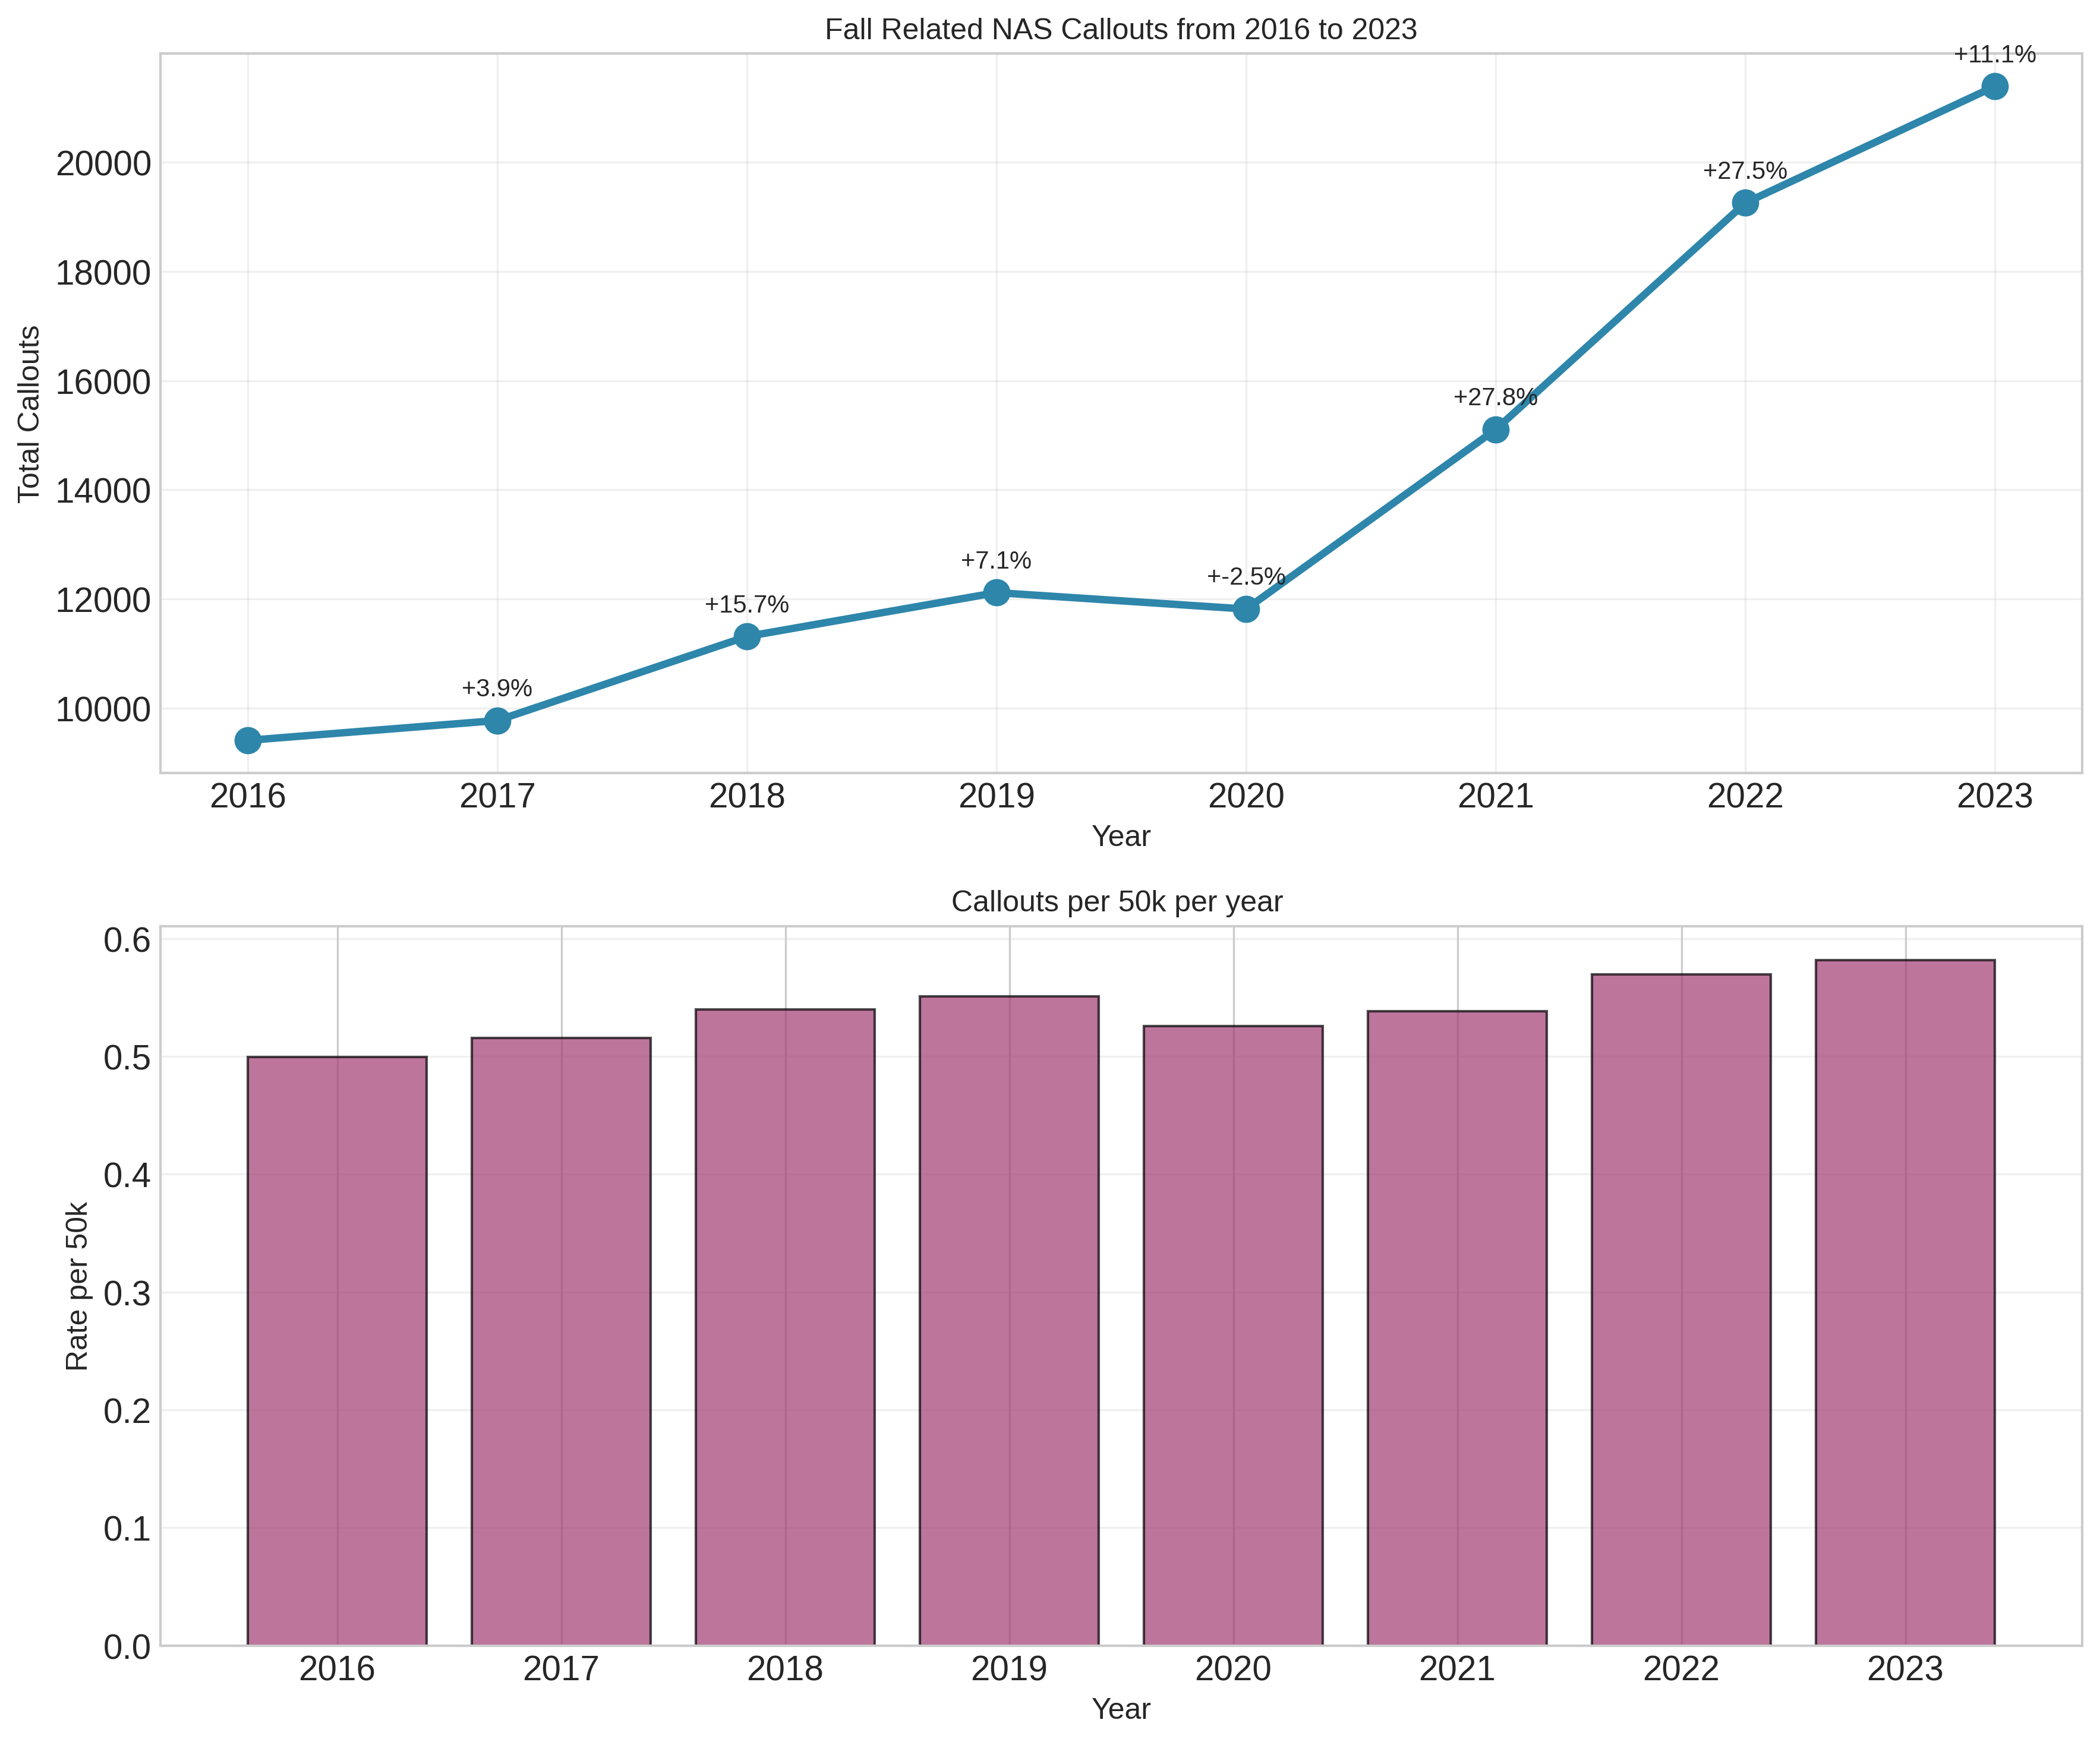


Regional Trend Sample (HSE Dublin and Midlands):


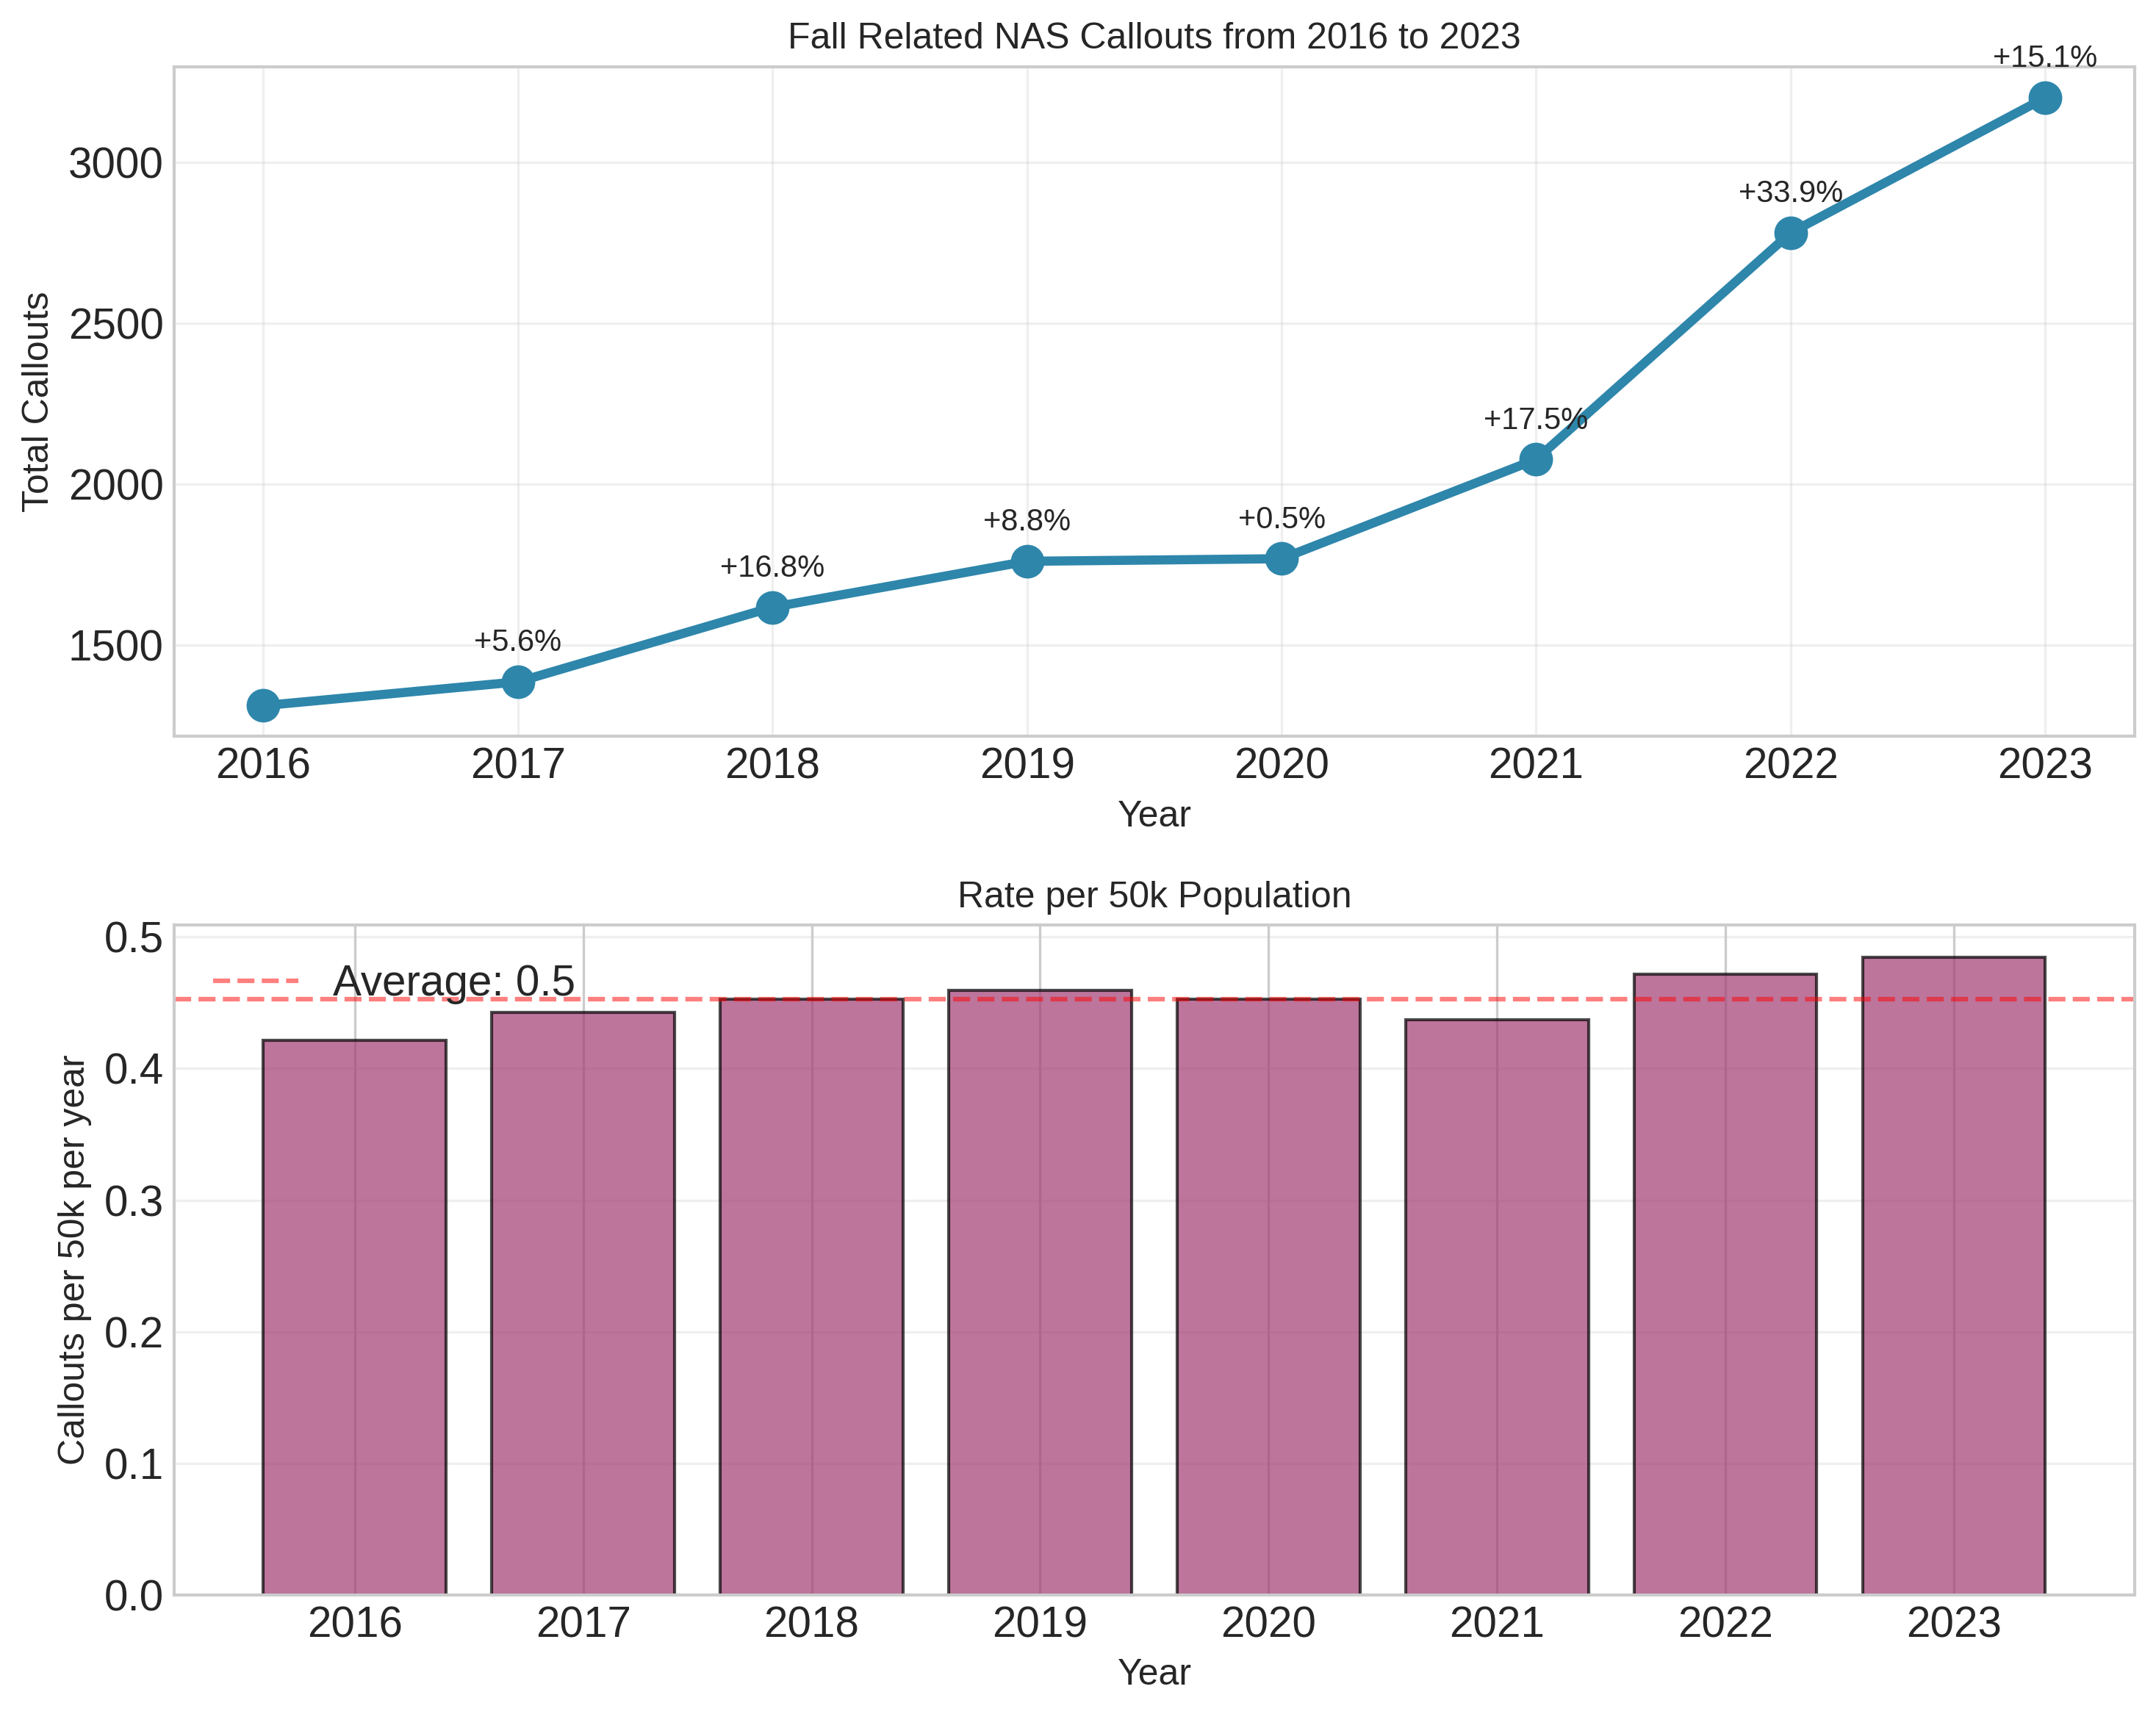

In [10]:
# Run the complete analysis
print("Starting comprehensive NAS plot generation...")
save_base_dir = "/home/paulharford/college/project/ul_project_Msc_AI/analysis/processed_data/visual_outputs/nas_weather/"

# Create all plots
all_files, paths = create_all_nas_plots(df_model, gp_results, save_path=save_base_dir)

print("\nPlot generation complete!")
print(f"Check the directory: {os.path.abspath(save_base_dir)}")

# Display sample plots
print("\nDisplaying sample plots from each category...")

# National sample
if 'trend' in all_files['national']:
    print("\nNational Trend:")
    display(Image(filename=all_files['national']['trend'], width=800))

# Regional sample
regions = list(all_files['regional'].keys())
if regions and 'trend' in all_files['regional'][regions[0]]:
    print(f"\nRegional Trend Sample ({regions[0]}):")
    display(Image(filename=all_files['regional'][regions[0]]['trend'], width=800))

In [11]:
def plot_weather_effects_by_region(gp_results, df):
    """Plot weather interaction effects by region with confidence intervals"""
    fig = plt.figure(figsize=(16, 12))
    
    # Extract all weather-related coefficients
    weather_params = []
    param_names = list(gp_results.params.index)
    
    # First, get the base cold weather effects for each severity at reference region (HSE Mid West)
    base_effects = {}
    for i, param in enumerate(param_names):
        if param.startswith('is_cold_weather:C(severity_group_detailed)'):
            if '[' in param and ']' in param:
                cat = param.split('[')[1].split(']')[0]
                base_effects[cat] = {
                    'coef': gp_results.params.iloc[i],
                    'se': gp_results.bse.iloc[i],
                    'p_value': gp_results.pvalues.iloc[i]
                }
    
    # Get the regional modifiers
    regional_modifiers = {}
    for i, param in enumerate(param_names):
        if param.startswith('is_cold_weather:C(region'):
            if '[T.' in param and ']' in param:
                region = param.split('[T.')[1].split(']')[0]
                regional_modifiers[region] = {
                    'coef': gp_results.params.iloc[i],
                    'se': gp_results.bse.iloc[i],
                    'p_value': gp_results.pvalues.iloc[i]
                }
    
    # Define regions
    regions = ['HSE Mid West (reference)'] + list(regional_modifiers.keys())
    severities = list(base_effects.keys())
    
    # Calculate effects for each region-severity combination
    for region in regions:
        for severity in severities:
            if region == 'HSE Mid West (reference)':
                # Reference region uses base effects only
                coef = base_effects[severity]['coef']
                se = base_effects[severity]['se']
                p_value = base_effects[severity]['p_value']
            else:
                # Other regions: base effect + regional modifier
                region_key = region.replace(' (reference)', '')
                coef = base_effects[severity]['coef'] + regional_modifiers.get(region_key, {'coef': 0})['coef']
                # For combined effects, we'd need covariance matrix for proper SE
                # Using approximation here
                se = np.sqrt(base_effects[severity]['se']**2 + regional_modifiers.get(region_key, {'se': 0})['se']**2)
                # Approximate p-value
                z_score = coef / se if se > 0 else 0
                p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
            
            ci_lower = coef - 1.96 * se
            ci_upper = coef + 1.96 * se
            
            weather_params.append({
                'region': region.replace('HSE ', ''),  # Shorten names
                'severity': severity,
                'coefficient': coef,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'p_value': p_value,
                'significant': p_value < 0.05
            })
    
    weather_df = pd.DataFrame(weather_params)
    
    # Create subplots for each severity type
    n_severities = len(severities)
    fig, axes = plt.subplots(n_severities, 1, figsize=(14, 4*n_severities))
    if n_severities == 1:
        axes = [axes]
    
    for idx, severity in enumerate(severities):
        ax = axes[idx]
        
        # Filter data for this severity
        severity_data = weather_df[weather_df['severity'] == severity].copy()
        severity_data = severity_data.sort_values('coefficient', ascending=True)
        
        # Plot
        y_pos = np.arange(len(severity_data))
        colors = ['red' if sig else 'gray' for sig in severity_data['significant']]
        
        # Calculate error bars
        errors = np.array([[row['coefficient'] - row['ci_lower'],
                           row['ci_upper'] - row['coefficient']] 
                          for _, row in severity_data.iterrows()]).T
        
        ax.barh(y_pos, severity_data['coefficient'], xerr=errors,
                color=colors, alpha=0.6, edgecolor='black', capsize=5)
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(severity_data['region'])
        ax.set_xlabel('Cold Weather Effect (Log Scale)', fontsize=11)
        ax.set_title(f'Cold Weather Effects for {severity.replace("_", " ").title()}\n(Red = Significant at p<0.05)', 
                     fontsize=12, fontweight='bold')
        
        # Add p-values
        for i, (_, row) in enumerate(severity_data.iterrows()):
            ax.text(0.98, i, f'p={row["p_value"]:.3f}', 
                    transform=ax.get_yaxis_transform(), fontsize=9, va='center', ha='right')
    
    plt.tight_layout()
    plt.show()  # Display the plot
    return fig, weather_df


def create_weather_heatmap(weather_df):
    """Create a heatmap of weather effects by region and severity"""
    # Pivot the data
    pivot_data = weather_df.pivot(index='region', columns='severity', values='coefficient')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Cold Weather Effect (Log Scale)'},
                ax=ax, vmin=-0.15, vmax=0.15)
    
    #ax.set_title('Cold Weather Effects Heatmap\n(By Region and Severity)', 
                 #fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Severity Category', fontsize=12)
    ax.set_ylabel('Region', fontsize=12)
    
    # Rotate x labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()  # Display the plot
    return fig


# Usage:
# fig1, weather_df = plot_weather_effects_by_region(gp_results, df)
# fig2 = create_weather_heatmap(weather_df)

# Additional analysis function
def summarize_regional_weather_effects(weather_df):
    """Print summary of weather effects by region"""
    print("\nSUMMARY OF WEATHER EFFECTS BY REGION")
    print("="*60)
    
    # Find regions with any significant effects
    sig_effects = weather_df[weather_df['significant']]
    if len(sig_effects) > 0:
        print("\nRegions with significant cold weather effects:")
        for _, row in sig_effects.iterrows():
            print(f"  - {row['region']}: {row['severity']} (coef={row['coefficient']:.3f}, p={row['p_value']:.3f})")
    else:
        print("\nNo regions show significant cold weather effects.")
    
    print("\nRegions ranked by average cold weather effect magnitude:")
    avg_effects = weather_df.groupby('region')['coefficient'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    for region, row in avg_effects.iterrows():
        print(f"  {region}: mean={row['mean']:.3f}, std={row['std']:.3f}")
    
    print("\nSeverity types ranked by average cold weather effect:")
    avg_severity = weather_df.groupby('severity')['coefficient'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    for severity, row in avg_severity.iterrows():
        print(f"  {severity}: mean={row['mean']:.3f}, std={row['std']:.3f}")
    
    return sig_effects, avg_effects, avg_severity


<Figure size 1600x1200 with 0 Axes>

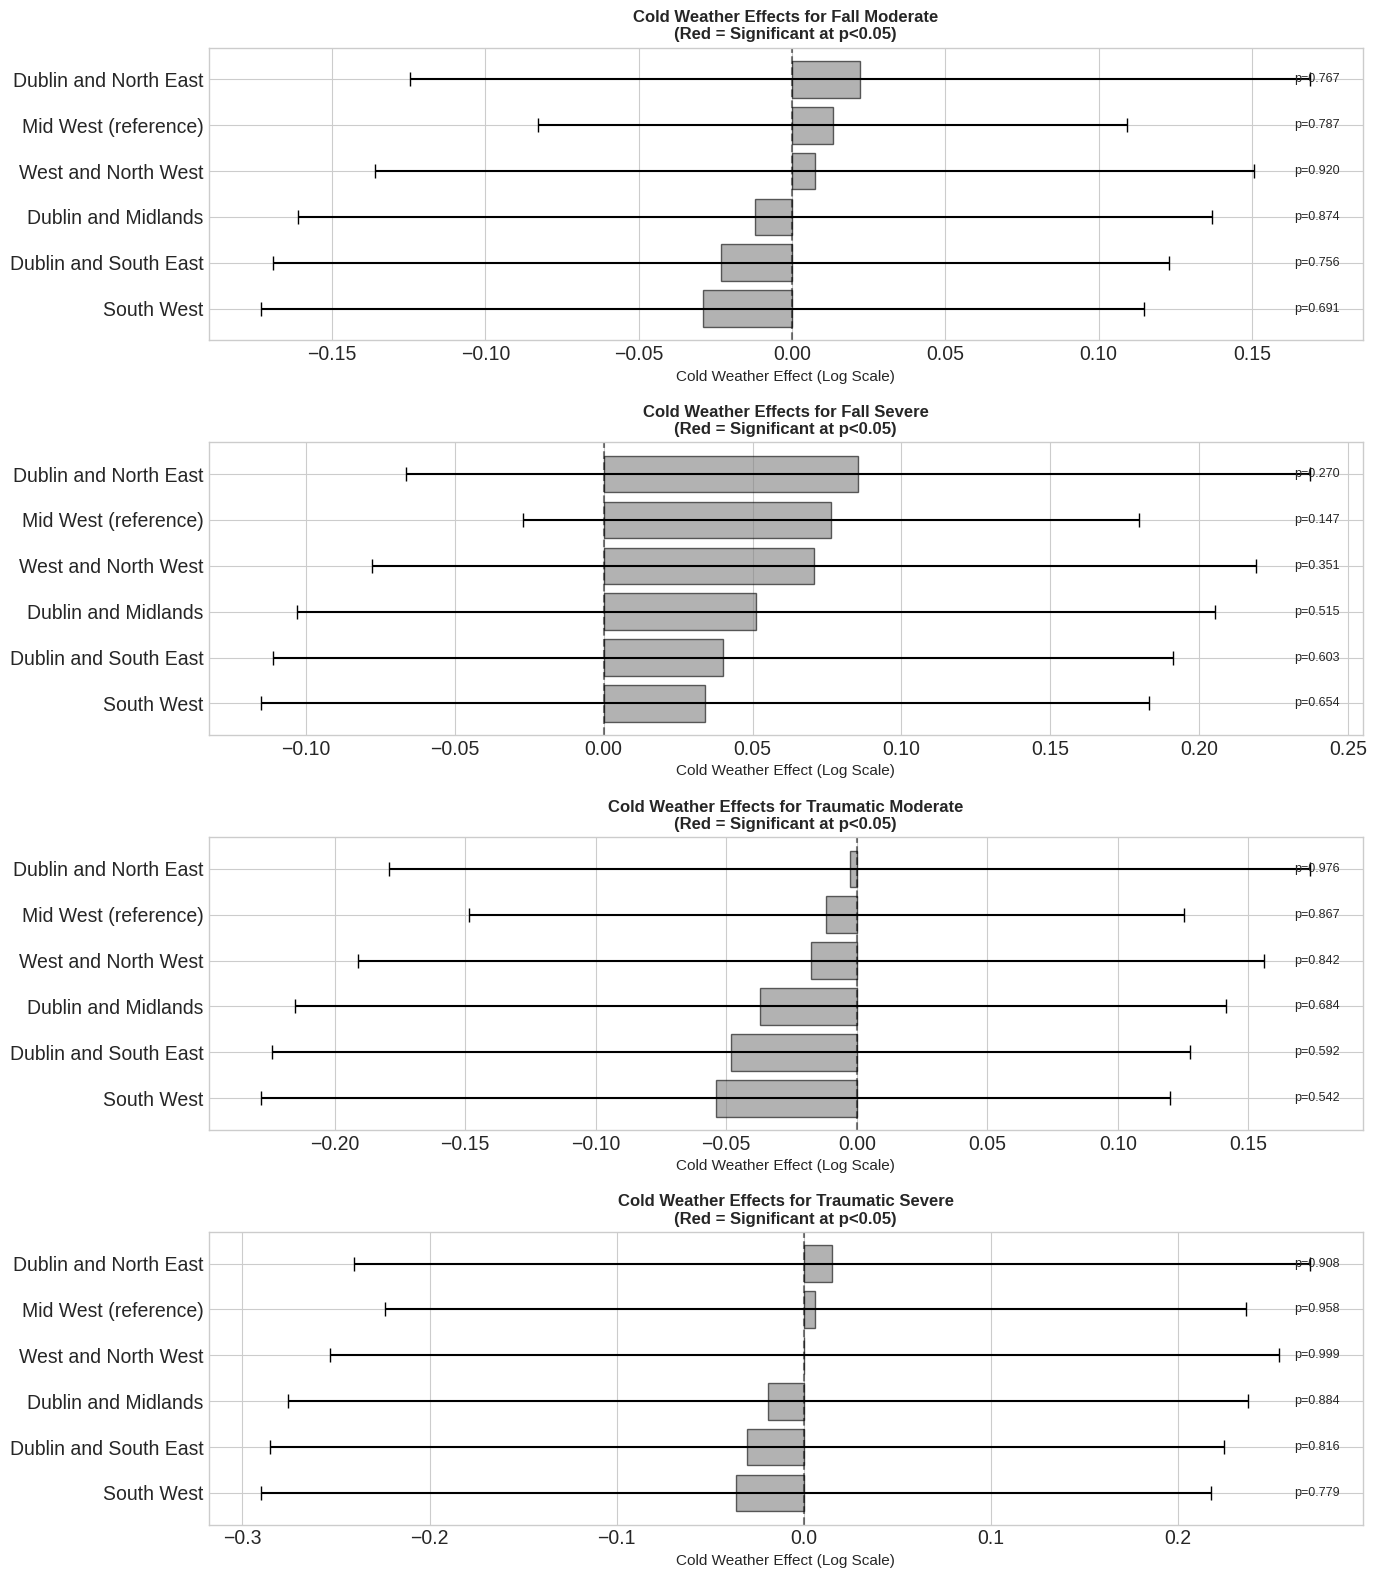

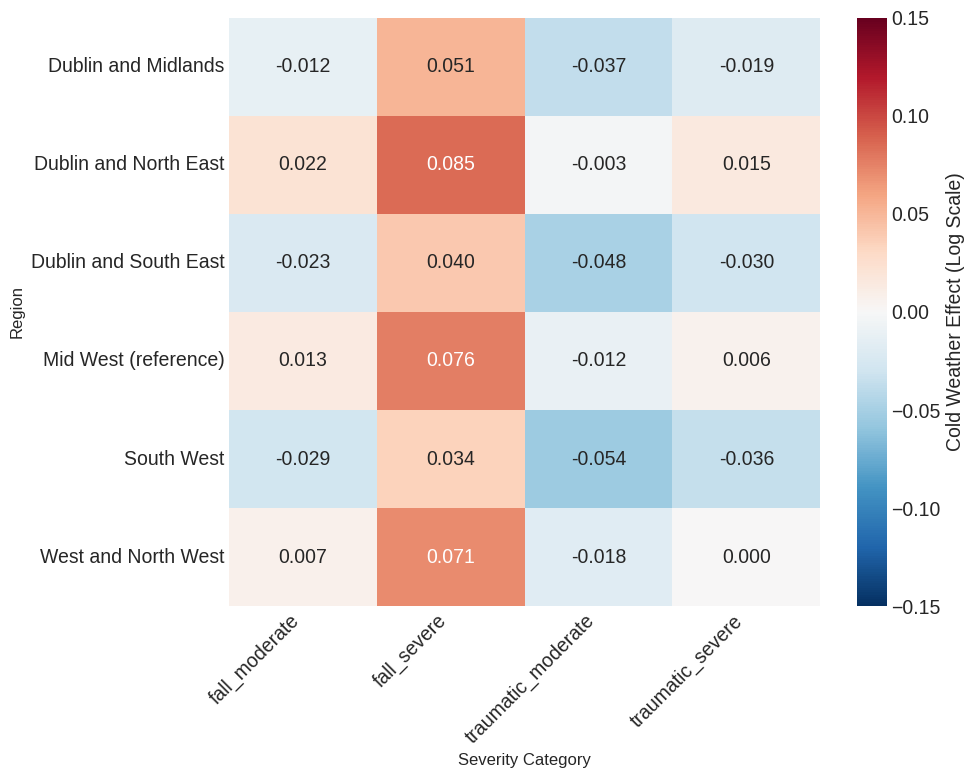

In [12]:
%matplotlib inline
fig1, weather_df = plot_weather_effects_by_region(gp_results, df_model)
fig2 = create_weather_heatmap(weather_df)



In [13]:

# Additional analysis function
def summarize_regional_weather_effects(weather_df):
    """Print summary of weather effects by region"""
    print("\nSUMMARY OF WEATHER EFFECTS BY REGION")
    print("="*60)
    
    # Find regions with any significant effects
    sig_effects = weather_df[weather_df['significant']]
    if len(sig_effects) > 0:
        print("\nRegions with significant cold weather effects:")
        for _, row in sig_effects.iterrows():
            print(f"  - {row['region']}: {row['severity']} (coef={row['coefficient']:.3f}, p={row['p_value']:.3f})")
    else:
        print("\nNo regions show significant cold weather effects.")
    
    print("\nRegions ranked by average cold weather effect magnitude:")
    avg_effects = weather_df.groupby('region')['coefficient'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    for region, row in avg_effects.iterrows():
        print(f"  {region}: mean={row['mean']:.3f}, std={row['std']:.3f}")
    
    print("\nSeverity types ranked by average cold weather effect:")
    avg_severity = weather_df.groupby('severity')['coefficient'].agg(['mean', 'std']).sort_values('mean', ascending=False)
    for severity, row in avg_severity.iterrows():
        print(f"  {severity}: mean={row['mean']:.3f}, std={row['std']:.3f}")
    
    return sig_effects, avg_effects, avg_severity